# Memory

- LLMs are often used for conversations.
- A fundamental component of a conversation is the ability to refer previous parts of the conversation exchange.
- But LLMs are stateless! 
- Idea: provide to the model a prompt which is the new input + a "memory" of the previous parts of conversation exchange.
- There are many ways to do this. A first distinction is between
  - passing (part of) the previous conversation _as is_ to the next input
  - summarize (in some way!) the previous conversation and pass the summary to the next input

In [13]:
from pprint import pprint

In [40]:
import matplotlib.pyplot as plt
import networkx as nx
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationTokenBufferMemory
from langchain.memory import ConversationBufferWindowMemory
from langchain.memory import ConversationSummaryMemory
from langchain.memory import ConversationKGMemory

In [67]:

# The Chat Model
chat_model = ChatOpenAI(
    openai_api_key=OPENAI_KEY,
    model_name="gpt-4",
    temperature=1,
    model_kwargs={"top_p":1},
)

NameError: name 'OPENAI_KEY' is not defined

In [6]:
my_prompt_1 = "Hi! I live in Geneva. Do you know in which country it is?"
response_1 = chat_model.predict(my_prompt_1)
print("# Response 1:")
print(response_1, "\n")

my_prompt_2 = "OK, great, and can you suggest me a museum near home?"
response_2 = chat_model.predict(my_prompt_2)
print("# Response 2:")
print(response_2)

# Response 1:
Yes, Geneva is located in Switzerland. 

# Response 2:
Sure! In order to recommend a museum near your home, I would need to know your location or at least the city or general area where you are located. Could you provide me with that information?


## Buffer Memory

This is the simplest memory, it just stores the last messages of the conversation.

In [15]:
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

In [16]:
response_1 = conversation.predict(input=my_prompt_1)
print("RESPONSE:", response_1, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi! I live in Geneva. Do you know in which country it is?
AI:

> Finished chain.
RESPONSE: Hello! Geneva is located in Switzerland. It is the second most populous city in Switzerland and is known for being a global center for diplomacy and finance. It is also situated on the western edge of Lake Geneva and is surrounded by the beautiful Swiss Alps. 



In [17]:
print(memory.buffer)

Human: Hi! I live in Geneva. Do you know in which country it is?
AI: Hello! Geneva is located in Switzerland. It is the second most populous city in Switzerland and is known for being a global center for diplomacy and finance. It is also situated on the western edge of Lake Geneva and is surrounded by the beautiful Swiss Alps.


In [18]:
response_2 = conversation.predict(input=my_prompt_2)
print("RESPONSE:", response_2, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi! I live in Geneva. Do you know in which country it is?
AI: Hello! Geneva is located in Switzerland. It is the second most populous city in Switzerland and is known for being a global center for diplomacy and finance. It is also situated on the western edge of Lake Geneva and is surrounded by the beautiful Swiss Alps.
Human: OK, great, and can you suggest me a museum near home?
AI:



> Finished chain.
RESPONSE: Certainly! There are several museums near Geneva that you might find interesting. One option is the Geneva History Museum, also known as Maison Tavel, which is located in the heart of the old town. It showcases the history of Geneva and features interactive exhibits that give you a glimpse into the city's past. Another option is the Patek Philippe Museum, which is dedicated to the art of watchmaking and showcases a stunning collection of timepieces. If you're interested in science and natural history, you might want to visit the Museum of Natural History in Geneva, which houses a vast collection of fossils, minerals, and other specimens. 



## Window Buffer Memory

- Same principle as Buffer Memory, but it stores the last messages of the conversation in a window of fixed size.
- Two different classes implementing this approach:
  - `ConversationBufferWindowMemory` — store `k` last messages
  - `ConversationTokenBufferMemory` — store `max_token_limit` last tokens

In [21]:
memory = ConversationBufferWindowMemory(k=5)
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

## Summary Memory

- Here the idea is to pass to the model as new prompt the new input plus a summary of the conversation so far.
- And how do we generate the summary? With a LLM, of course!
- Therefore, we need to pass in the constructor of the Memory object a LLM that will be used to generate the summary.

In [25]:
memory = ConversationSummaryMemory(llm=chat_model)
conversation = ConversationChain(
    llm=chat_model,
    memory=memory,
    verbose=True,
)

In [26]:
response_1 = conversation.predict(input=my_prompt_1)
print("RESPONSE:", response_1, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi! I live in Geneva. Do you know in which country it is?
AI:

> Finished chain.
RESPONSE: Hi! Geneva is located in Switzerland. 



In [27]:
print(memory.buffer)

The human asks the AI about the location of Geneva. The AI responds that Geneva is located in Switzerland.


In [28]:
response_2 = conversation.predict(input=my_prompt_2)
print("RESPONSE:", response_2, "\n")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
The human asks the AI about the location of Geneva. The AI responds that Geneva is located in Switzerland.
Human: OK, great, and can you suggest me a museum near home?
AI:

> Finished chain.
RESPONSE: Sure! I can suggest the Musée d'Art et d'Histoire (Museum of Art and History) in Geneva, Switzerland. It's known for its extensive collection of fine art and archaeological artifacts. Another option is the Patek Philippe Museum, which showcases the history of watchmaking and has a vast collection of timepieces. 



## Knowledge Graph Memory

- Information about the previous conversation can be summarized as a string.
- But this is not the only option. For instance, we can decide to summarize the previous conversation as a knowledge graph.

In [62]:
memory = ConversationKGMemory(llm=chat_model)

In [63]:
text = """
Aspirin causes several different effects in the body, mainly the reduction of inflammation, analgesia
(relief of pain), the prevention of clotting, and the reduction of fever. Much of this is believed
to be due to decreased production of prostaglandins and TXA2. Aspirin's ability to suppress the
production of prostaglandins and thromboxanes is due to its irreversible inactivation of the
cyclooxygenase (COX) enzyme.
"""

# Save context from this conversation to buffer. This will update the internal KG memory.
memory.save_context({"input": text}, {"output": ""})

In [64]:
print(type(memory.kg._graph))
print(memory.kg._graph)

<class 'networkx.classes.digraph.DiGraph'>
DiGraph with 9 nodes and 8 edges


In [65]:
my_graph = memory.kg._graph

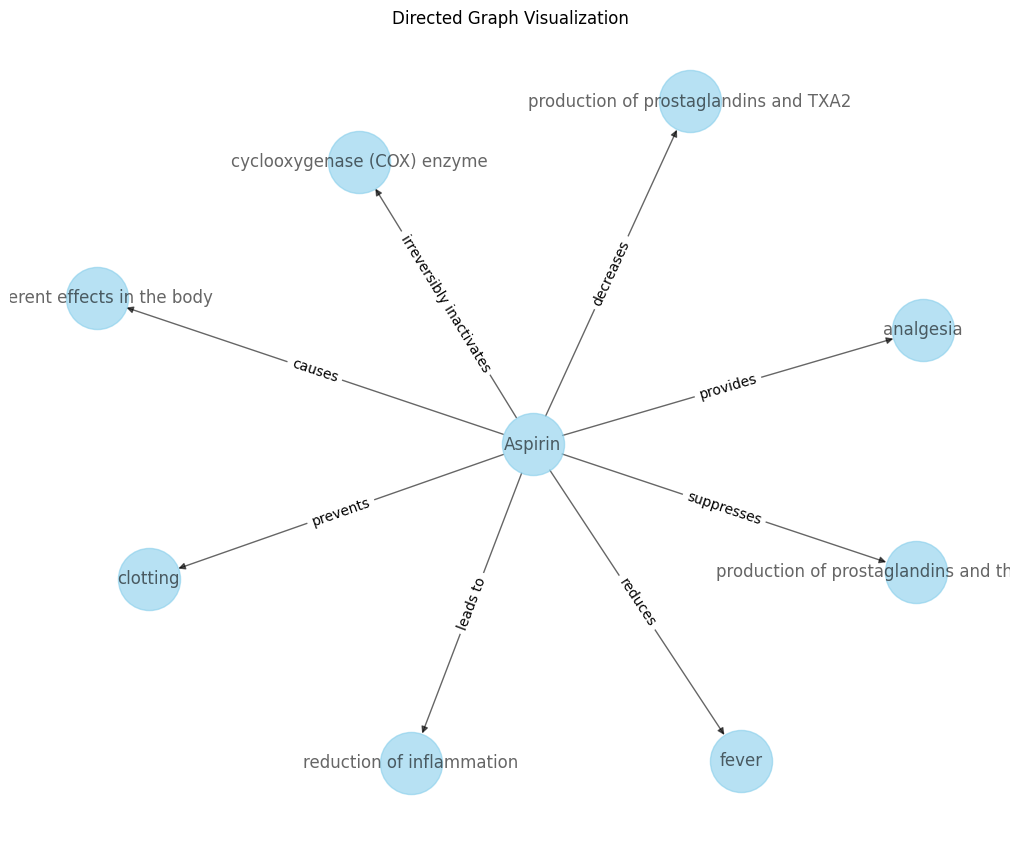

In [66]:

# Draw the graph
plt.figure(figsize=(10,8))
pos = nx.spring_layout(my_graph)  # Positioning of nodes
nx.draw(my_graph, pos, with_labels=True, node_size=2000, node_color="skyblue", node_shape="o", alpha=0.6, linewidths=1)

# Extract relation attributes for edge labels
edge_labels = {(u, v): my_graph[u][v]['relation'] for u, v in my_graph.edges()}

nx.draw_networkx_edge_labels(my_graph, pos, edge_labels=edge_labels, label_pos=0.5)
plt.title("Directed Graph Visualization")
plt.show()
